In [0]:
"""
Notebook de recalage temporel des séries temporelles pour alignement sur l'instant de défaut.

Ce notebook transforme les séries temporelles étiquetées en recalant le temps t=0 
au moment exact où le défaut apparaît, permettant ainsi une comparaison cohérente 
entre toutes les simulations. Pour les fichiers sans défaut, un recalage aléatoire 
est appliqué pour maintenir la diversité. Il effectue les opérations suivantes :

1. **Recalage temporel pour tous les dossiers sauf FiltreAir** :
   - Lecture des fichiers depuis fichiers_etiquettes_defaut/
   - Utilisation de la fonction extract_active_start() pour identifier le timestamp de défaut
   - Gestion des cas classiques via fault_mapping (NoiseTOT, bool_eta_comp, etc.)
   - Cas spécial Tuyaux : extraction des 4 booléens/starts de fuites
   - Cas spécial Mix : recherche du minimum des patterns S[A-Z]+_(\d+) > 0
   - Suppression pattern "NoiseTOT_0_StartTOT_0_" pour Defaut_Fuite_Fuel
   - Recalage : df["Time"] = df["Time"] - start_defaut pour aligner t=0 sur défaut
   - Sans défaut : recalage aléatoire t_fake ∈ [0, 2000] pour diversité
   - Filtrage Time >= 0 et réindexation avec reset_index(drop=True)
   - Linspace uniforme : Time = [0, 0.1, 0.2, ...] avec pas de 0.1s
   - Sauvegarde dans fichiers_temps_recalé/

2. **Traitement spécifique pour FiltreAir** :
   - Mapping dédié : {"Foul": "SF"} car logique différente
   - Fonction extract_active_start_filtreair() spécialisée
   - Extraction pattern : Foul_1 → SF_XXX pour temps de début
   - Même logique de recalage : t=0 aligné sur début défaut
   - Recalage aléatoire si pas de défaut détecté
   - Reconstruction temps uniforme avec np.linspace
   - Arrondi à 6 décimales avec np.round pour précision

3. **Vérification et visualisation** :
   - Vérification spécifique FiltreAir : cohérence à t≈0
   - Test : si Time ≈ 0 (tolérance 0.0001), alors Defaut doit être cohérent
   - Défaut attendu = 1 si start_defaut existe, 0 sinon
   - Comptage et listing des mismatches détectés
   - Graphique exemple : série temporelle Defaut avec ligne verticale t=0
   - Visualisation steps-post pour signal binaire
   - Validation visuelle de l'alignement temporel

Paramètres techniques :
- DOSSIER_SOURCE : fichiers_etiquettes_defaut/ (fichiers étiquetés)
- DOSSIER_SORTIE : fichiers_temps_recalé/ (créé automatiquement)
- Pas temporel : 0.1 seconde (uniforme après recalage)
- Plage recalage aléatoire : [0, 2000] secondes
- Tolérance vérification : 0.0001 pour Time ≈ 0

Logique de recalage :
- Avec défaut : Time_nouveau = Time_original - start_defaut
- Sans défaut : Time_nouveau = Time_original - random(0, 2000)
- Filtrage : garder seulement Time_nouveau >= 0
- Réindexation : Time_final = [0, 0.1, 0.2, ..., 0.1*(N-1)]

Cas spéciaux gérés :
- FiltreAir : mapping Foul→SF distinct du reste
- Defaut_Mix_Final : minimum des S[TYPE]_XXX > 0
- Tuyaux : 4 fuites possibles simultanément
- Fuite_Fuel : suppression pattern parasite NoiseTOT_0

Résultats produits :
- Toutes les séries alignées sur t=0 au moment du défaut
- Pas de temps uniforme 0.1s pour toutes les séries
- Conservation de la colonne Defaut avec cohérence temporelle
- Fichiers sans défaut avec décalage aléatoire pour robustesse

"""

In [0]:
import os
import re
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [0]:
DOSSIER_SOURCE = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/fichiers_etiquettes_defaut"
DOSSIER_SORTIE = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/fichiers_temps_recalé"
os.makedirs(DOSSIER_SORTIE, exist_ok=True)


In [0]:
DOSSIERS = [
    "Defaut_CC_T",
    "Defaut_Compresseur",
    "Defaut_Fuite_Fuel",
    "Defaut_Noise_TOT",
    "Defaut_Rec_T",
    "Defaut_Recuperateur",
    "Defaut_Turbine",
    "FiltreAir",
    "Defaut_Mix_Final",
    "Defaut_Tuyaux_cc_t",
    "Defaut_Tuyaux_comp_rec",
    "Defaut_Tuyaux_rec_cc",
    "Defaut_Tuyaux_turb_rec"
]

DOSSIER_SANS_DEFAUT = "Dossier_Sans_Defaut_Final"

In [0]:
fault_mapping = {
    "Foul": "SF",  # pour FiltreAir : booléen -> temps de début du défaut
    "Foul": "SFR",  # pour Defaut_Recuperateur
    "NoiseTOT": "StartTOT",
    "NoiseFuel": "StartFuel",
    "bool_eta_comp_deg": "start_comp_eff",
    "bool_eta_turb": "start",
    "bool_foul_CC_turb": "start_foul_CC_turb",
    "bool_foul_recup_turb": "start_foul_T_REC"
}


1. Recalage temporel pour tout les dossiers défauts sauf FiltreAir

In [0]:
def extract_active_start(filename, dossier):
    starts = []

    if dossier not in ["Defaut_Mix_Final"]: # Cas classique -> utilisation du mapping
        for bool_key, start_key in fault_mapping.items():
            bool_match = re.search(f"{bool_key}_(\d)", filename)
            if bool_match and bool_match.group(1) == "1":
                start_match = re.search(f"{start_key}_?(\d+)", filename)
                if start_match:
                    starts.append(int(start_match.group(1)))

        fuite_bool_match = re.search(r"boolFuites_(\d)_(\d)_(\d)_(\d)", filename) # Cas Tuyaux
        fuite_start_match = re.search(r"startFuites_(\d+)_(\d+)_(\d+)_(\d+)", filename)
        if fuite_bool_match and fuite_start_match:
            bools = list(map(int, fuite_bool_match.groups()))
            starts_all = list(map(int, fuite_start_match.groups()))
            starts += [s for b, s in zip(bools, starts_all) if b == 1]

    elif dossier == "Defaut_Mix_Final": # Cas Mix
        s_matches = re.findall(r"S[A-Z]+_(\d+)", filename)
        s_values = [int(val) for val in s_matches if int(val) > 0]
        if s_values:
            starts.append(min(s_values))

    return min(starts) if starts else None

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/root/.ipykernel/1174479/command-6811636406426051-958282887:8: SyntaxWarning: invalid escape sequence '\d'
  bool_match = re.search(f"{bool_key}_(\d)", filename)
/root/.ipykernel/1174479/command-6811636406426051-958282887:10: SyntaxWarning: invalid escape sequence '\d'
  start_match = re.search(f"{start_key}_?(\d+)", filename)


In [0]:
fichiers = [f for f in os.listdir(DOSSIER_SOURCE) if f.endswith(".csv")]

for fichier in fichiers:
    chemin = os.path.join(DOSSIER_SOURCE, fichier)
    df = pd.read_csv(chemin)

    nom_dossier = fichier.split("__")[0]

    if nom_dossier == "Defaut_Fuite_Fuel":
        fichier_clean = re.sub(r"NoiseTOT_0_StartTOT_0_", "", fichier)
    else:
        fichier_clean = fichier

    start_defaut = extract_active_start(fichier_clean, nom_dossier) # Extraction du temps de début de défaut 

    if start_defaut is not None:
        df = df[df["Time"] >= start_defaut].copy()  # Recalage pour les cas avec défaut
        df["Time"] = df["Time"] - start_defaut
    else:
        t_fake = random.randint(0, 2000) # Si pas de défaut → on fait un recalage aléatoire
        df = df[df["Time"] >= t_fake].copy()
        df["Time"] = df["Time"] - t_fake

    df = df[df["Time"] >= 0].reset_index(drop=True)
    df["Time"] = np.round(np.linspace(0, 0.1 * (len(df) - 1), len(df)), 6)

    df.to_csv(os.path.join(DOSSIER_SORTIE, fichier), index=False)
    print(f"[OK] Recalage fait pour : {fichier}")

print("\n==> Recalage temporel terminé pour tous les fichiers.")


[OK] Recalage fait pour : Defaut_CC_T__Sim_100_N_72.05_TOT_559.11_Tamb_279.80_pamb_0.99_perc_fool_CC2T_0.008182_bool_foul_CC_turb_1_start_foul_CC_turb_1685_T_c_out_init_332.7405_T_t_out_init_603.6400_TIT_init_698.3848.csv
[OK] Recalage fait pour : Defaut_CC_T__Sim_101_N_82.36_TOT_670.82_Tamb_280.54_pamb_0.91_perc_fool_CC2T_0.009275_bool_foul_CC_turb_1_start_foul_CC_turb_1326_T_c_out_init_330.7693_T_t_out_init_589.4647_TIT_init_679.9412.csv
[OK] Recalage fait pour : Defaut_CC_T__Sim_10_N_87.96_TOT_678.18_Tamb_311.11_pamb_0.92_perc_fool_CC2T_0.009075_bool_foul_CC_turb_1_start_foul_CC_turb_515_T_c_out_init_356.0056_T_t_out_init_673.3906_TIT_init_784.3933.csv
[OK] Recalage fait pour : Defaut_CC_T__Sim_11_N_93.63_TOT_550.86_Tamb_303.86_pamb_1.02_perc_fool_CC2T_0.010520_bool_foul_CC_turb_1_start_foul_CC_turb_393_T_c_out_init_325.6076_T_t_out_init_466.8520_TIT_init_516.2511.csv
[OK] Recalage fait pour : Defaut_CC_T__Sim_12_N_70.04_TOT_623.21_Tamb_286.81_pamb_1.01_perc_fool_CC2T_0.012214_bool_

2. Recalage temporel pour defaut FiltreAir

In [0]:
mapping_filtreair = {"Foul": "SF"} # Mapping spécifique pour FiltreAir


In [0]:
def extract_active_start_filtreair(filename):
    starts = []
    for bool_key, start_key in mapping_filtreair.items():
        bool_match = re.search(f"{bool_key}_(\d)", filename)
        if bool_match and bool_match.group(1) == "1":
            start_match = re.search(f"{start_key}_?(\d+)", filename)
            if start_match:
                starts.append(int(start_match.group(1)))
    return min(starts) if starts else None


<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/root/.ipykernel/1174479/command-8740766154689891-449352764:4: SyntaxWarning: invalid escape sequence '\d'
  bool_match = re.search(f"{bool_key}_(\d)", filename)
/root/.ipykernel/1174479/command-8740766154689891-449352764:6: SyntaxWarning: invalid escape sequence '\d'
  start_match = re.search(f"{start_key}_?(\d+)", filename)


In [0]:
print("\n=== RECALAGE FiltreAir UNIQUEMENT ===\n")

DOSSIER_FILTRE = "FiltreAir"
fichiers_filtreair = [f for f in os.listdir(DOSSIER_SOURCE) if f.startswith("FiltreAir__") and f.endswith(".csv")]

for fichier in fichiers_filtreair:
    chemin = os.path.join(DOSSIER_SOURCE, fichier)
    df = pd.read_csv(chemin)

    start_defaut = extract_active_start_filtreair(fichier)

    if start_defaut is not None:
        df = df[df["Time"] >= start_defaut].copy()
        df["Time"] = df["Time"] - start_defaut
    else:
        t_fake = random.randint(0, 2000)
        df = df[df["Time"] >= t_fake].copy()
        df["Time"] = df["Time"] - t_fake

    df = df[df["Time"] >= 0].reset_index(drop=True)
    df["Time"] = np.round(np.linspace(0, 0.1 * (len(df) - 1), len(df)), 6)

    df.to_csv(os.path.join(DOSSIER_SORTIE, fichier), index=False)
    print(f"[OK] Recalage fait pour : {fichier}")

print("\n==> Recalage terminé pour FiltreAir.")



=== RECALAGE FiltreAir UNIQUEMENT ===

[OK] Recalage fait pour : FiltreAir__Sim_100_N_89.4507_TOT_612.3723_Tamb_272.3597_pamb_0.94_percAsh_0.0001007_Foul_1_SF_425.csv
[OK] Recalage fait pour : FiltreAir__Sim_10_N_63.0342_TOT_510.7900_Tamb_289.6899_pamb_1.02_percAsh_0.0001004_Foul_1_SF_1138.csv
[OK] Recalage fait pour : FiltreAir__Sim_11_N_78.7756_TOT_502.3804_Tamb_280.0061_pamb_1.01_percAsh_0.0001149_Foul_1_SF_1057.csv
[OK] Recalage fait pour : FiltreAir__Sim_12_N_66.6259_TOT_620.3964_Tamb_276.2986_pamb_0.99_percAsh_0.0001499_Foul_1_SF_901.csv
[OK] Recalage fait pour : FiltreAir__Sim_13_N_63.3529_TOT_545.7954_Tamb_308.8169_pamb_1.01_percAsh_0.0001331_Foul_1_SF_1993.csv
[OK] Recalage fait pour : FiltreAir__Sim_14_N_63.1270_TOT_588.5357_Tamb_268.4826_pamb_0.90_percAsh_0.0001520_Foul_1_SF_1635.csv
[OK] Recalage fait pour : FiltreAir__Sim_15_N_94.7478_TOT_516.8872_Tamb_283.1391_pamb_1.01_percAsh_0.0001245_Foul_1_SF_1822.csv
[OK] Recalage fait pour : FiltreAir__Sim_16_N_67.2739_TOT_552.760

In [0]:
print("\n=== VERIFICATION SPECIFIQUE POUR FiltreAir ===\n")

fichiers_filtreair = [f for f in os.listdir(DOSSIER_SORTIE) if f.startswith("FiltreAir__") and f.endswith(".csv")]

nb_checked = 0
nb_mismatch = 0
liste_mismatch = []

for fichier_test in fichiers_filtreair:
    chemin_test = os.path.join(DOSSIER_SORTIE, fichier_test)
    df_test = pd.read_csv(chemin_test).dropna()

    start_defaut = extract_active_start_filtreair(fichier_test)

    df_zero = df_test[abs(df_test["Time"]) < 0.0001]

    if not df_zero.empty:
        ligne = df_zero.iloc[0]
        valeur_defaut = ligne["Defaut"]

        if (start_defaut is None and valeur_defaut == 0) or (start_defaut is not None and valeur_defaut == 1):
            print(f"[OK] {fichier_test} → Defaut = {valeur_defaut}")
        else:
            print(f"[MISMATCH] {fichier_test} → Defaut = {valeur_defaut}")
            nb_mismatch += 1
            liste_mismatch.append(fichier_test)
    else:
        print(f"[!] Pas de ligne Time ≈ 0 dans {fichier_test}")

    nb_checked += 1

print(f"\n=== VERIFICATION FINALE FiltreAir ===")
print(f"Total fichiers vérifiés : {nb_checked}")
print(f"Fichiers avec mismatch : {nb_mismatch}")

if liste_mismatch:
    print("\nListe des fichiers en mismatch :")
    for fichier in liste_mismatch:
        print(f"- {fichier}")
else:
    print("\nAucun mismatch trouvé !")

print("=== FIN ===")



=== VERIFICATION SPECIFIQUE POUR FiltreAir ===

[OK] FiltreAir__Sim_100_N_89.4507_TOT_612.3723_Tamb_272.3597_pamb_0.94_percAsh_0.0001007_Foul_1_SF_425.csv → Defaut = 1.0
[OK] FiltreAir__Sim_10_N_63.0342_TOT_510.7900_Tamb_289.6899_pamb_1.02_percAsh_0.0001004_Foul_1_SF_1138.csv → Defaut = 1.0
[OK] FiltreAir__Sim_11_N_78.7756_TOT_502.3804_Tamb_280.0061_pamb_1.01_percAsh_0.0001149_Foul_1_SF_1057.csv → Defaut = 1.0
[OK] FiltreAir__Sim_12_N_66.6259_TOT_620.3964_Tamb_276.2986_pamb_0.99_percAsh_0.0001499_Foul_1_SF_901.csv → Defaut = 1.0
[OK] FiltreAir__Sim_13_N_63.3529_TOT_545.7954_Tamb_308.8169_pamb_1.01_percAsh_0.0001331_Foul_1_SF_1993.csv → Defaut = 1.0
[OK] FiltreAir__Sim_14_N_63.1270_TOT_588.5357_Tamb_268.4826_pamb_0.90_percAsh_0.0001520_Foul_1_SF_1635.csv → Defaut = 1.0
[OK] FiltreAir__Sim_15_N_94.7478_TOT_516.8872_Tamb_283.1391_pamb_1.01_percAsh_0.0001245_Foul_1_SF_1822.csv → Defaut = 1.0
[OK] FiltreAir__Sim_16_N_67.2739_TOT_552.7606_Tamb_270.4269_pamb_1.02_percAsh_0.0001364_Foul_1_SF_

3. Vérification de la procédure par visualisation

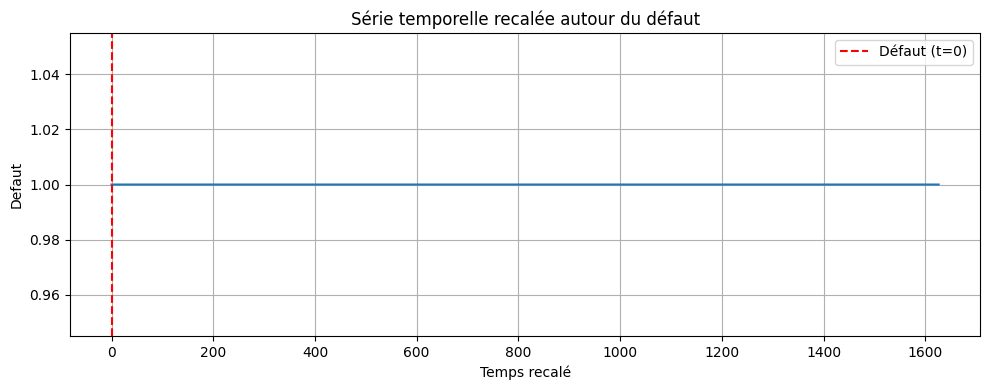

In [0]:
plt.figure(figsize=(10, 4))
plt.plot(df["Time"], df["Defaut"], drawstyle="steps-post")
plt.axvline(0, color='r', linestyle='--', label="Défaut (t=0)")
plt.title("Série temporelle recalée autour du défaut")
plt.xlabel("Temps recalé")
plt.ylabel("Defaut")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()